<a href="https://colab.research.google.com/github/rynwhd/Language-Models/blob/main/Deep_LearningwithNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget -nc https://lazyprogrammer.me/course_files/AirlineTweets.csv


--2023-03-01 18:07:25--  https://lazyprogrammer.me/course_files/AirlineTweets.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3421431 (3.3M) [text/csv]
Saving to: ‘AirlineTweets.csv’

AirlineTweets.csv   100%[===================>]   3.26M  4.24MB/s    in 0.8s    

2023-03-01 18:07:27 (4.24 MB/s) - ‘AirlineTweets.csv’ saved [3421431/3421431]



In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

In [3]:
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

In [4]:
np.random.seed(0)
tf.random.set_seed(0)

In [5]:
df=pd.read_csv('AirlineTweets.csv')

In [6]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [7]:
df=df[['airline_sentiment','text']]

<AxesSubplot:>

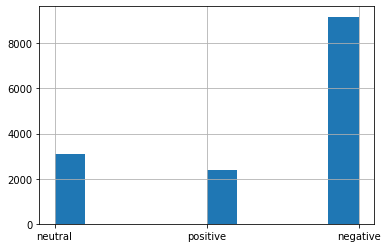

In [8]:
df['airline_sentiment'].hist()

In [9]:
df=df[df['airline_sentiment']!='neutral'].copy()

In [10]:
target_map={'positive':1,'negative':0}
df['target']=df['airline_sentiment'].map(target_map)

In [11]:
df.head()

,airline_sentiment,text,target
1,positive,@VirginAmerica plus you've added commercials t...,1
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0
5,negative,@VirginAmerica seriously would pay $30 a fligh...,0
6,positive,"@VirginAmerica yes, nearly every time I fly VX...",1


In [12]:
df.shape

(11541, 3)

In [13]:
df_train,df_test=train_test_split(df,random_state=42)

In [14]:
df_train.shape

(8655, 3)

In [15]:
vectorizer=TfidfVectorizer(max_features=2000)
X_train=vectorizer.fit_transform(df_train['text'])
X_test=vectorizer.transform(df_test['text'])

In [16]:
X_train

<8655x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 131089 stored elements in Compressed Sparse Row format>

In [17]:
#input layer cannot be sparse matrix, so converting it to array
X_train=X_train.toarray()
X_test=X_test.toarray()

In [18]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [19]:
D=X_train.shape[1]

In [20]:
i=Input(shape=(D,))
x=Dense(1)(i)
model=Model(i,x)

In [21]:
model.summary()
#we have 2000 inputs and on top we have a bias term

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2000)]            0         
                                                                 
 dense (Dense)               (None, 1)                 2001      
                                                                 
Total params: 2,001
Trainable params: 2,001
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.compile(
    loss=BinaryCrossentropy(from_logits=True),
    optimizer=Adam(learning_rate=.01),
    metrics=['accuracy']
)

In [23]:
y_train=df_train['target']
y_test=df_test['target']

In [24]:
r=model.fit(
    X_train,y_train,
    validation_data=(X_test,y_test),
    epochs=40,
    batch_size=128
)

Epoch 1/40
68/68 [==============================] - 3s 15ms/step - loss: 0.5048 - accuracy: 0.7920 - val_loss: 0.3978 - val_accuracy: 0.8049
Epoch 2/40
68/68 [==============================] - 1s 10ms/step - loss: 0.3761 - accuracy: 0.7963 - val_loss: 0.3396 - val_accuracy: 0.8212
Epoch 3/40
68/68 [==============================] - 1s 13ms/step - loss: 0.3224 - accuracy: 0.8180 - val_loss: 0.3029 - val_accuracy: 0.8416
Epoch 4/40
68/68 [==============================] - 1s 20ms/step - loss: 0.2852 - accuracy: 0.8451 - val_loss: 0.2770 - val_accuracy: 0.8607
Epoch 5/40
68/68 [==============================] - 1s 12ms/step - loss: 0.2577 - accuracy: 0.8640 - val_loss: 0.2583 - val_accuracy: 0.8766
Epoch 6/40
68/68 [==============================] - 1s 11ms/step - loss: 0.2368 - accuracy: 0.8805 - val_loss: 0.2445 - val_accuracy: 0.8881
Epoch 7/40
68/68 [==============================] - 1s 9ms/step - loss: 0.2203 - accuracy: 0.8923 - val_loss: 0.2337 - val_accuracy: 0.9002
Epoch 8/40
68/

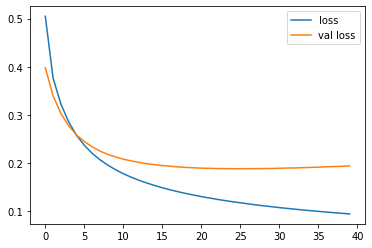

In [25]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val loss')
plt.legend()

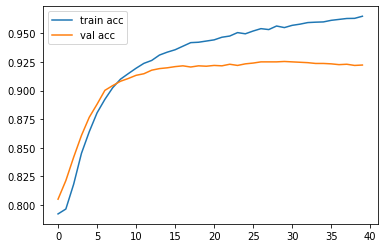

In [26]:
plt.plot(r.history['accuracy'],label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()

In [27]:
P_train=((model.predict(X_train)>0)*1.0).flatten()
P_test=((model.predict(X_test)>0)*1.0).flatten()

91/91 [==============================] - 0s 2ms/step


In [28]:
cm=confusion_matrix(y_train,P_train,normalize='true')
cm

array([[0.99095551, 0.00904449],
       [0.09833333, 0.90166667]])

<AxesSubplot:>

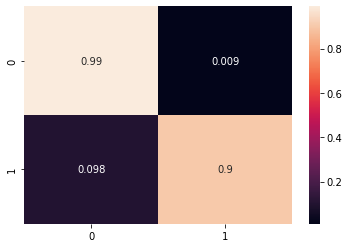

In [29]:
sns.heatmap(cm,annot=True)

<AxesSubplot:>

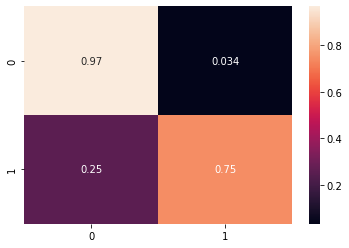

In [30]:
cm_test=confusion_matrix(y_test,P_test,normalize='true')
sns.heatmap(cm_test,annot=True)

In [31]:
Pr_train=model.predict(X_train)
Pr_test=model.predict(X_test)
print('Train AUC:',roc_auc_score(y_train,Pr_train))
print('Test AUC:',roc_auc_score(y_test,Pr_test))

91/91 [==============================] - 0s 2ms/step
Train AUC: 0.9950039711483912
Test AUC: 0.9547310125251462


In [32]:
print('Train F1:',f1_score(y_train,P_train))
print('Test F1:',f1_score(y_test,P_test))

Train F1: 0.9314203730272597
Test F1: 0.7917059377945335


In [33]:
model.layers

In [34]:
w=model.layers[1].get_weights()[0]

In [35]:
word_index_map=vectorizer.vocabulary_
word_index_map

{'jetblue': 973,
 'thanks': 1726,
 'for': 753,
 'having': 855,
 'us': 1859,
 'hang': 838,
 'out': 1262,
 'at': 197,
 'tampa': 1708,
 'airport': 122,
 'forever': 756,
 'today': 1767,
 'it': 964,
 'really': 1420,
 'been': 243,
 'an': 147,
 'awesome': 217,
 'experience': 654,
 'americanair': 143,
 'was': 1898,
 'told': 1770,
 'you': 1993,
 'could': 452,
 'only': 1245,
 'refund': 1434,
 'me': 1107,
 'the': 1730,
 'cost': 448,
 'of': 1224,
 'my': 1179,
 'original': 1254,
 'return': 1476,
 'flight': 726,
 'note': 1211,
 'had': 828,
 'booked': 273,
 'more': 1164,
 'expensive': 653,
 'everyone': 635,
 'else': 602,
 'outstanding': 1267,
 'united': 1842,
 'denver': 516,
 'to': 1766,
 'austin': 207,
 'still': 1660,
 'on': 1239,
 'ground': 820,
 'issue': 961,
 'is': 959,
 'lack': 999,
 'announcement': 151,
 'made': 1086,
 'so': 1606,
 'late': 1010,
 'when': 1929,
 'gate': 793,
 'agent': 113,
 'there': 1734,
 'over': 1268,
 'hour': 897,
 'southwestair': 1626,
 'hold': 880,
 '30': 36,
 'min': 1141,
